<a href="https://colab.research.google.com/github/nigoda/machine_learning/blob/main/23_Image_classification_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Image classification**
This code shows how to classify cat or dog from images. It build an image classifier using `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. You will get some practical experience and develop intuition for the following concepts:

*   Building data *input pipelines* using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model. 
*   *Overfitting* -How to identify and prevent it.
*   *Data augmentation* and *dropout* -Key techniques to fight overfitting in computer vision tasks to incorporate into data pipeline and image classification model.

Follows a basic machine learning workflow:
1.  Examine and understand data
2.  Build an input pipeline
3.  Build the model
4.  Train the model
5.  Test the model
6.  Improve the model and repeat the process




https://www.tensorflow.org/tutorials/images/classification

chiranth will join engineering

### **Import Packages**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tenosorflow and the Keras classes needed to construct our model.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tensorflow-gpu
except Exception:
  pass



     |████████████████████████████████| 454.3MB 40kB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


### **Load data**
Begin by downloading the dataset. Uses a filtered version of Dogs vs Cats dataset from Kaggle. Download the archive version of the dataset and store it in the "/tmp/" directory.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 0s 0us/step


After extraction its contents, assign variables with the proper file path for the training and validation set.

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

### **Understand the data**

Let's look at how many cats and dogs images are in the training and validation directory:

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images: ', num_cats_tr)
print('total training dog images: ', num_dogs_tr)

print('total validation cat images: ', num_cats_val)
print('total validation dog images: ', num_dogs_val)
print('--')

print('Total training images: ', total_train)
print('total validation images: ',total_val )

total training cat images:  1000
total training dog images:  1000
total validation cat images:  500
total validation dog images:  500
--
Total training images:  2000
total validation images:  1000


For convenience set up variable to use while pre-processing the dataset and training the network.

In [ ]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

### **Data preparation**

Format the images into appropriately pre-processed floating point tensor before feeding to the network:

1.  Read images from the disk.
2.  Decode contents of these images and convert it into proper grid format as per their RGB content.
3.  Convert them into floating point tensors.
4.  Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural network prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors-helpful when training the network.

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

After defining the generator for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### **Visualize training images**

Visualize the training images by extracting a batch of images from the training generator-which is 32 images in this example-then plot five of them with matplotlib.

In [ ]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. The return value of next function is in form of(x_train, y_train) where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

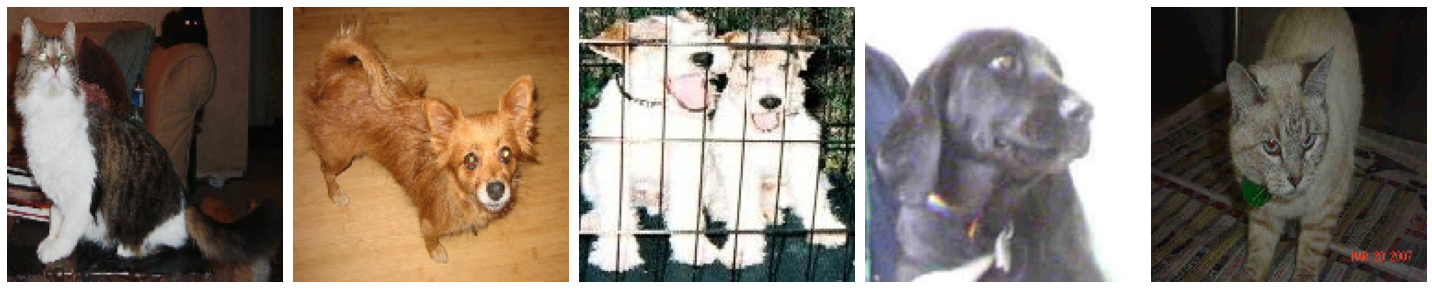

In [ ]:
plotImages(sample_training_images[:5])

### **Create the model**

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function. The model outputs class probabilities based on binary classification by the sigmoid activation function.

In [ ]:
model = Sequential([
    Conv2D(16,3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64,3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

### **Compile the model**

For this, choose the *ADAM* optimizer and *binary cross entropy loss* function. To view training and validation accuracy for each training epoch, pass metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### **Model summary**

View all the layer of the network using the model's summary method

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

### **Train the model**

Use the fit_generator method of the ImageDataGenerator class to train the network.

In [ ]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps = total_val // batch_size
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
15/15 [==============================] - 45s 3s/step - loss: 0.8656 - accuracy: 0.5027 - val_loss: 0.6860 - val_accuracy: 0.6317
Epoch 2/15
15/15 [==============================] - 43s 3s/step - loss: 0.6747 - accuracy: 0.6229 - val_loss: 0.6628 - val_accuracy: 0.5368
Epoch 3/15
15/15 [==============================] - 44s 3s/step - loss: 0.6232 - accuracy: 0.6495 - val_loss: 0.6064 - val_accuracy: 0.6708
Epoch 4/15
15/15 [==============================] - 43s 3s/step - loss: 0.5886 - accuracy: 0.6806 - val_loss: 0.5809 - val_accuracy: 0.6953
Epoch 5/15
15/15 [==============================] - 44s 3s/step - loss: 0.5250 - accuracy: 0.7333 - val_loss: 0.5797 - val_accuracy: 0.7109
Epoch 6/15
15/15 [==============================] - 43s 3s/step - loss: 0.5193 - accuracy: 0.7484 - val_loss: 0.5806 - val_accuracy: 0.6942
Epoch 7/15
15/15 [==============================] - 44s 3s/step - loss: 0.4773 - accuracy: 0.7724 - val_loss: 0.5904 - val_accuracy: 0.7087
Epoch 8/15
15/15 [==

### **Visualize training results**

Now visualize the results after training the network.

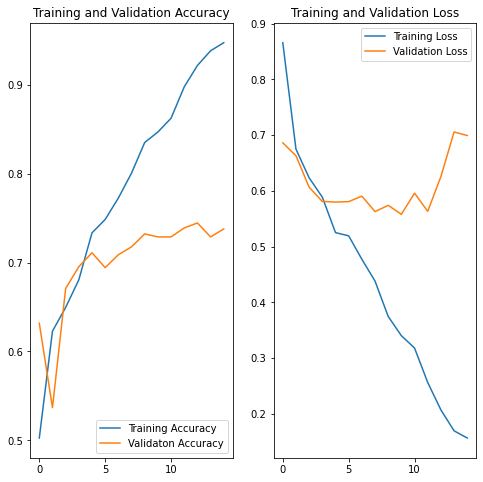

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validaton Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 70% accuracy on the validation set.

let's look at what went wrong and try to increase overall performance of the model.

### **Overfitting**

In the plots above, the training accuracy is increasing lineraly over time, whereas validation accuracy stall araound 70% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable-a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples- to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a diffcult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data *augmentation* and add *dropout* to our model.

### **Data augmentation**

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training sample by augmenting the sample using random transformation that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement that in `tf.keras` using `ImageDataGenerator` class. Pass different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

**Apply horizontal flip**

Pass horizontal flip augmentation to the `ImageDataGenrator` class and set it to true to apply this augmentation.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

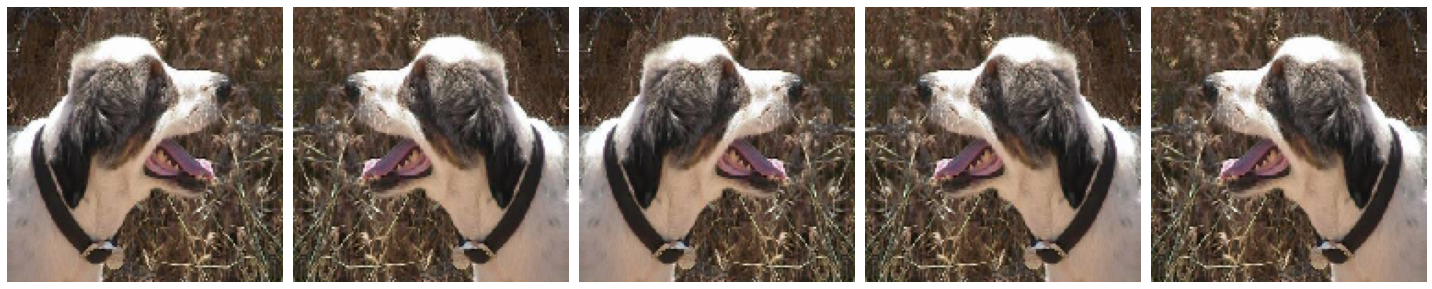

In [ ]:
# Re-use the same custom plotting function define and used above to visualize the training images
plotImages(augmented_images)

**Randomly rotate the image**

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [ ]:
 image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


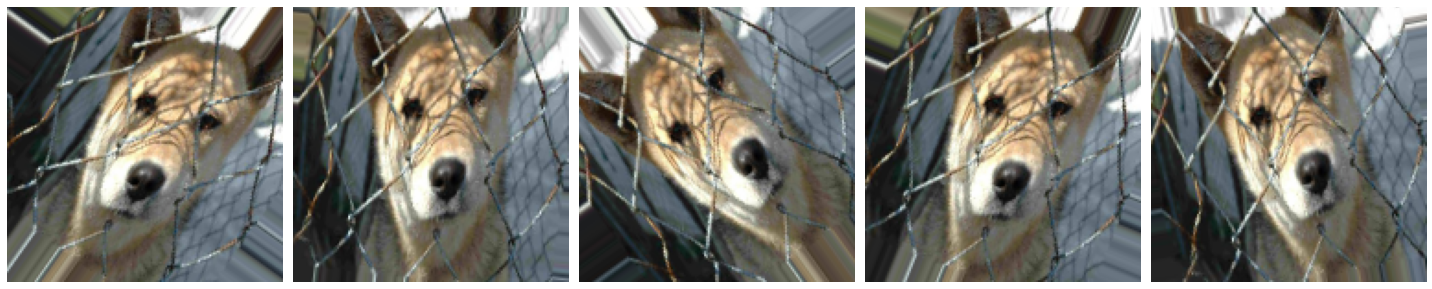

In [ ]:
plotImages(augmented_images)

**Apply zoom augmentation**

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

In [ ]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


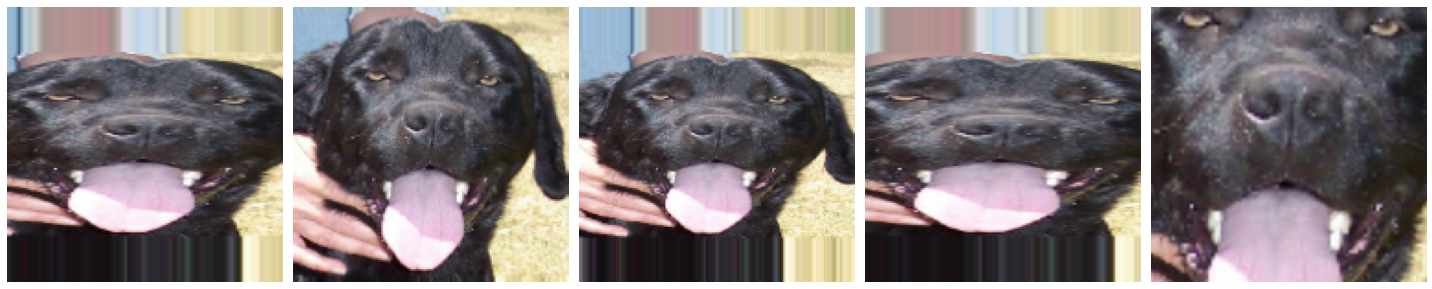

In [ ]:
plotImages(augmented_images)

**Put it all together**

Apply all the previous augmentations. Here, you appiled rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [ ]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=.15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

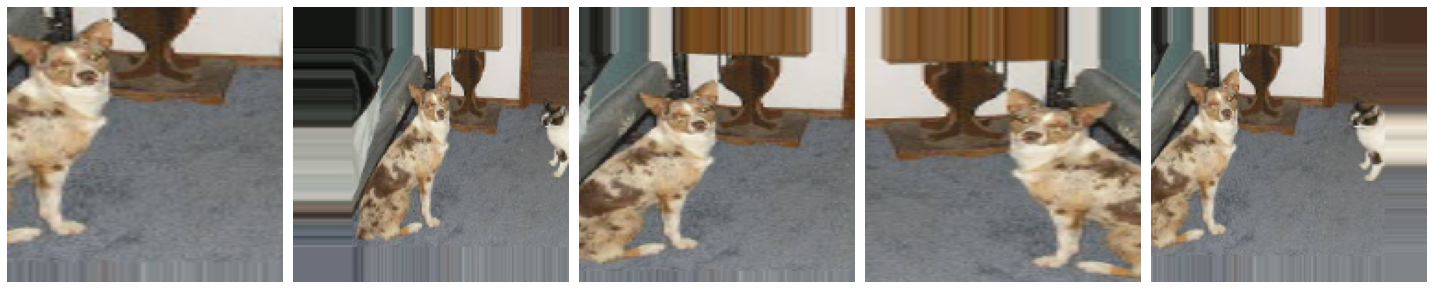

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### **Create validation data generator**

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batch using `ImageDataGenerator`.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen =  image_gen_val.flow_from_directory(batch_size=batch_size,
                                                  directory=validation_dir,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


## **Dropout**

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and network can reduce overfitting on small training examples. Dropout is one of the regularizaton technique.

When you apply dropout to a layer it randomly drop out(set zero) number of output units from the applied layer during the training proccess. Dropout takes a fraction number as its input values, in the form such as 0.1, 0.2, 0.4 etc. This means droppning out 10%, 20%, 40% of the output unit randomly from applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epochs.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.



### **Creating a new network with Dropouts.**

fully connected layer output units, are randomly set to zero during each training epochs.


In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu',
           input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

### **Compile the model**

After introducing dropouts to the network, compile the model and view the layers summary.

In [ ]:
model_new.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics='accuracy')

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)       

### **Train the model**

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps=total_val // batch_size
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
15/15 [==============================] - 54s 4s/step - loss: 1.7236 - accuracy: 0.4861 - val_loss: 0.6932 - val_accuracy: 0.4944
Epoch 2/15
15/15 [==============================] - 52s 3s/step - loss: 0.6929 - accuracy: 0.5064 - val_loss: 0.6924 - val_accuracy: 0.4967
Epoch 3/15
15/15 [==============================] - 52s 3s/step - loss: 0.6935 - accuracy: 0.4834 - val_loss: 0.6930 - val_accuracy: 0.5045
Epoch 4/15
15/15 [==============================] - 52s 3s/step - loss: 0.6930 - accuracy: 0.5027 - val_loss: 0.6930 - val_accuracy: 0.5089
Epoch 5/15
15/15 [==============================] - 52s 3s/step - loss: 0.6930 - accuracy: 0.5208 - val_loss: 0.6928 - val_accuracy: 0.5435
Epoch 6/15
15/15 [==============================] - 52s 3s/step - loss: 0.6929 - accuracy: 0.5219 - val_loss: 0.6927 - val_accuracy: 0.5033
Epoch 7/15
15/15 [==============================] - 52s 4s/step - loss: 0.6926 - accuracy: 0.5224 - val_loss: 0.6921 - val_accuracy: 0.5167
Epoch 8/15
15/15 [==

Text(0.5, 1.0, 'Training and Validation Loss')

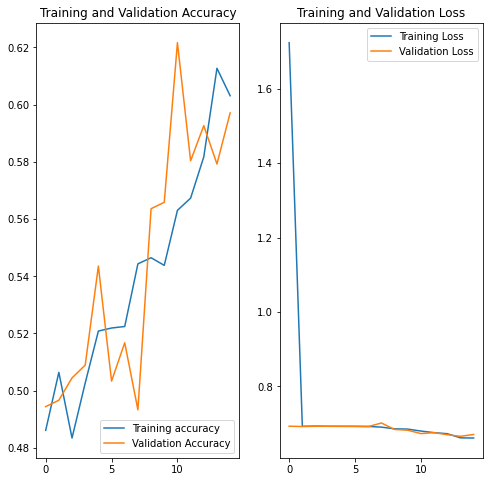

In [ ]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model_new.layers

In [ ]:
layer_outputs = [layer.output for layer in model_new.layers[:8]]
layer_outputs

[<KerasTensor: shape=(None, 150, 150, 16) dtype=float32 (created by layer 'conv2d_6')>,
 <KerasTensor: shape=(None, 75, 75, 16) dtype=float32 (created by layer 'max_pooling2d_6')>,
 <KerasTensor: shape=(None, 75, 75, 16) dtype=float32 (created by layer 'dropout_3')>,
 <KerasTensor: shape=(None, 75, 75, 32) dtype=float32 (created by layer 'conv2d_7')>,
 <KerasTensor: shape=(None, 37, 37, 32) dtype=float32 (created by layer 'max_pooling2d_7')>,
 <KerasTensor: shape=(None, 37, 37, 64) dtype=float32 (created by layer 'conv2d_8')>,
 <KerasTensor: shape=(None, 18, 18, 64) dtype=float32 (created by layer 'max_pooling2d_8')>,
 <KerasTensor: shape=(None, 18, 18, 64) dtype=float32 (created by layer 'dropout_4')>]

In [ ]:
layer_names = [layer.name for layer in model_new.layers[:8]]
layer_names

['conv2d_6',
 'max_pooling2d_6',
 'dropout_3',
 'conv2d_7',
 'max_pooling2d_7',
 'conv2d_8',
 'max_pooling2d_8',
 'dropout_4']

In [ ]:
activation_model =tf.keras.models.Model(inputs=model_new.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a model could have any number of inputs and outputs.

This one has one input and 8 outputs, one output per layer activation.

In [ ]:
activations = activation_model.predict(train_data_gen[0])

ValueError: ignored